# Reuters News Classification

Jared Neumann 
<br>
22 November 2021

## Introduction

In the following notebook, I show two possible ways of classifying the entries in the *Reuters-21578 text categorization test collection* corpus [[1]](#1). The first uses a Linear Support Vector Classifier (LSV) to learn and predict the categories of entries. The second uses a Multinomial Naive Bayes Classifier (MNB) to learn and predict whether entries are categorized as 'earn' or not. Commentary, including the advantages and disadvantages of each approach, is provided throughout.

The notebook is divided into two parts. The first part, Building and Testing the Models, gives a step-by-step walkthrough of the process taken in building, testing, and analyzing the models and their performance. The second part, Loading and Running the Models, allows the user to load the models saved in the previous part and run them with new data.

Note: The paths used refer to my own drive folder structure, but should work fine if a shortcut to the folder is added to your Colab Notebooks folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Building and Testing the Models

### Importing Libraries

This project primarily relies on Scikit-learn modules [[2]](#2), but also uses Beautiful Soup [[3]](#3) and Pandas [[4]](#4) for convenient formatting. 

In [ ]:
import os, re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import pickle

### Processing and Compiling the Corpus

The dataset (in the data folder) is in .sgm files with corresponding markup and a stylesheet detailing the strategy employed. I elected to convert the data into a single dataset of dictionaries with all the information that was relevant for the aforementioned approaches. No preprocessing (other than that which is built into scikit-learn's CountVectorizer and TfidfVectorizer) was performed outside of ensuring that the contents of the data were utf-8 encoded, in xml-safe format for Beautiful Soup, and free of superfluous and otherwise undesirable symbols like '\n'.

In [ ]:
def minor_preprocess(file):

  with open(file, 'rb') as f:
    lines = f.readlines()
    utf8_safe_lines = [line.decode('utf-8', 'ignore') for line in lines]
    xml_safe_lines = [re.sub(r'&#\d*;', '', line) for line in utf8_safe_lines] # Get rid of problematic strings
    no_newlines = [line.replace('\n', ' ') for line in xml_safe_lines]
  f.close()

  return ''.join(no_newlines)


The files contained 1000 entries each, except for the last one. All entries were parsed into a single dataset, retaining all information, and converted into a dictionary.

In [ ]:
def compile_data(datapath='/content/drive/MyDrive/Colab Notebooks/Reuters News Classification/data'):
  dataset = []
  for file in os.listdir(datapath):
    if file.endswith('.sgm'):
      preprocessed_data = minor_preprocess(datapath + '/' + file)
      records = [record + '</REUTERS>' for record in preprocessed_data.split('</REUTERS>') if record] # Retain all original formatting
      dataset.extend(records)
  
  return dataset

For the purposes of this project, only four labels were deemed necessary, as indicated in the following function. The labels and contents were extracted into a corresponding dictionary.

In [ ]:
def compile_dictionary(data):
  
  data_dict = {
      'REUTERS TOPICS': '', # Initialize each key with some value. Important for the try/except block.
      'TOPICS': 'none', # Consider empty topics as a new category, 'none'. See next section.
      'TITLE': '',
      'BODY': '',
      }

  # Grab the Reuters Topics between the following tags
  start = data.find('<REUTERS TOPICS="') + len('<REUTERS TOPICS="')
  end = data.find('" LEWISSPLIT=')
  data_dict['REUTERS TOPICS'] = data[start:end]


  soup = BeautifulSoup(data, 'xml')

  # Use a try/except block to grab Topics, Title, and Body in case they are empty
  # If empty, the default value remains unchanged
  try:
    if soup.TOPICS.contents:
      data_dict['TOPICS'] = soup.TOPICS.D.contents[0]

    if soup.TITLE.contents:
      data_dict['TITLE'] = soup.TITLE.contents[0]

    if soup.BODY.contents:
      body = soup.BODY.contents[0]
      data_dict['BODY'] = soup.BODY.contents[0]
  except AttributeError:
    pass

  return data_dict


In [ ]:
# Get a list of all documents
dataset = compile_data()

In [ ]:
# Convert the list into a dictionary with fields of interest
dataset_dicts = [compile_dictionary(data) for data in dataset]

### About the Data

According to the README, if REUTERS TOPICS contains YES, but no topics are given in TOPICS, then the articles "can reasonably be considered negative examples of all 135 topics." [[5]](#5) Thus these entries should be retained. If REUTERS TOPICS contains NO, but some topic is given, then it was added after the original indexing. Thus they too should be retained. However, if REUTERS TOPICS contains NO and no topics were given, then it is still ambiguous whether they were intended as negative examples or not. Thus these entries should be dismissed from the dataset. **I have included only those entries that satisfies these conditions by including only those entries that either have topics *or* state that there are topics.**

In [ ]:
dataset_dicts = [data for data in dataset_dicts if data['TOPICS'] != 'none' or data['REUTERS TOPICS'] == 'YES']

In some cases, there is **no text in the BODY** field, but the article is still categorized. **In those cases, I used the TITLE field as the BODY** since that is all the categorizer had to go on.

In [ ]:
for data in dataset_dicts:
  if data['BODY'] == '':
    data['BODY'] = data['TITLE']

Finally, for convenience, I have used **pandas** to manage and display the data.

In [ ]:
df = pd.DataFrame(dataset_dicts)

In [ ]:
df

,REUTERS TOPICS,TOPICS,TITLE,BODY
0,YES,earn,ISLAND TELEPHONE SHARE SPLIT APPROVED,<Island Telephone Co Ltd> said the previously ...
1,YES,trade,U.K. GROWING IMPATIENT WITH JAPAN - THATCHER,Prime Minister Margaret Thatcher said the U.K....
2,YES,earn,QUESTECH INC <QTEC> YEAR NET,"Shr loss nil vs profit 19 cts Net loss 3,1..."
3,YES,none,ASLK-CGER FINANCE ISSUES 10 BILLION YEN BOND,ASLK-CGER Finance NV is issuing a 10 billion y...
4,YES,crude,CANADA OIL EXPORTS RISE 20 PCT IN 1986,Canadian oil exports rose 20 pct in 1986 over ...
...,...,...,...,...
13146,YES,gas,RECENT U.S. OIL DEMAND UP 1.9 PCT FROM YEAR AGO,U.S. oil demand as measured by products suppli...
13147,YES,earn,"(MONTREAL CITY, DISTRICT SAVINGS BANK) 1ST QTR",Shr 33 cts vs 24 cts Net 6.2 mln vs 4.9 ml...
13148,YES,gold,FRANCO NEVADA SAYS STOCK RISE DUE TO DRILLING,Franco Nevada Mining Corp Ltd said the gain in...
13149,YES,acq,BUSINESSMAN HAS 8.9 PCT OF DEL E. WEBB <DWP.A>,"John Cotton, an Arizona businessman, told the ..."


### Multiclass Classification

One drawback of multiclass classification is that it requires a certain **threshold** for the number of classes for cross-validation and the train-test split. The minimum required for 3-fold cross-validation on the training set in addition to a test set is 4. **Classes with fewer than 4 entries were thus removed**.

In [ ]:
df = df[df.groupby('TOPICS').TOPICS.transform('count') > 3]

Another thing to note about the dataset in order to train a model properly is that it is **unbalanced** in terms of the number of classes represented. Thus **stratified sampling** was used to get accurate proportions for the training and testing sets during the splitting process. Note that this process is otherwise random and specific to my current purposes, so does not correspond to the splits noted in the dataset itself.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['BODY'], df['TOPICS'], train_size=0.75, stratify=df['TOPICS'])

In [ ]:
y_test

9353         earn
8410         earn
2856     money-fx
8369         ship
359           gnp
           ...   
11369         acq
4356     money-fx
10087       trade
6129        grain
10665        earn
Name: TOPICS, Length: 3278, dtype: object

The **LSV classifier** is a support vector machine which treats each class as if it were linearly separable and attempts to draw that line which separates them within some margin. The default setting for scikit-learn's LSV is to treat multiple classes via a **one-vs-rest** or one-vs-all strategy. More information can be found in the [User Guide](https://scikit-learn.org/stable/modules/svm.html). Class weights were set to 'balanced' to give each class a weight inversely proportional to the frequency of its entries so each category is treated similarly by the regression function. The choice of this function itself is rich with possibilities that would be explored in a different format.

Furthermore, **parameters** were tuned via scikit-learn's **GridSearchCV** module which allows multiple possible parameters to be tried in combination with the best being selected for the final fit. **Validation** is done using a **3-fold cross-validation** scheme on the training set so there is no leak of information about the test set in the learning process.

Finally, the choice of parameters to adjust were chosen to give a sense of variety in a couple of variables while keeping the runtime within reasonable bounds. **Expect a runtime of about 10 minutes using Google's SequentialBackend with 1 worker**.


In [ ]:
lsv_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC(random_state=0, class_weight='balanced'))
    ])

params = {
        'vect__ngram_range':[(2,2),(1,2),(2,3)],
        'clf__C':[0.9, 1.0],
        'tfidf__use_idf':[True, False]
    }

gs_clf = GridSearchCV(lsv_clf, params, cv=3, verbose=2)
gs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(2, 2); total time=   9.0s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(2, 2); total time=   8.8s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(2, 2); total time=   8.8s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(1, 2); total time=  10.5s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(1, 2); total time=  10.9s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(1, 2); total time=  10.7s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(2, 3); total time=  24.5s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(2, 3); total time=  25.8s
[CV] END clf__C=0.9, tfidf__use_idf=True, vect__ngram_range=(2, 3); total time=  25.5s
[CV] END clf__C=0.9, tfidf__use_idf=False, vect__ngram_range=(2, 2); total time=   7.5s
[CV] END clf__C=0.9, tfidf__use_idf=False, vect__ngram_range=(2, 2);

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=0))]),
             param_grid={'clf__C': [0.9, 1.0], 'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(2, 2), (1, 2), (2, 3)]},
             verbose=2)

In [ ]:
# Get the best parameters and print them.
best_params = gs_clf.best_params_
print()
print("+-------------------------------------------------------+")
print(" Best parameters:")
print("+-------------------------------------------------------+")
for key in best_params.keys():
  print(key + ': ' + str(best_params[key]))
print()


+-------------------------------------------------------+
 Best parameters:
+-------------------------------------------------------+
clf__C: 1.0
tfidf__use_idf: True
vect__ngram_range: (1, 2)



In [ ]:
# Save the trained model with the best parameters
with open('/content/drive/MyDrive/Colab Notebooks/Reuters News Classification/models/trained_lsvc.sav', 'wb+') as save:
  pickle.dump(gs_clf, save)

Using the best-fit model, we can **predict** the labels for the testing set and generate a report about how it did compared to the actual labels.

In [ ]:
preds = gs_clf.predict(X_test)

In [ ]:
report = classification_report(y_test, preds, digits=4)
print("+-------------------------------------------------------+")
print(" Classification report:")
print("+-------------------------------------------------------+")
print(report)

+-------------------------------------------------------+
 Classification report:
+-------------------------------------------------------+
                 precision    recall  f1-score   support

            acq     0.8526    0.9643    0.9050       588
           alum     1.0000    0.9231    0.9600        13
            bop     0.5789    0.7857    0.6667        14
        carcass     0.6667    0.2857    0.4000         7
          cocoa     1.0000    0.9412    0.9697        17
         coffee     0.8857    1.0000    0.9394        31
         copper     0.8667    0.8125    0.8387        16
           corn     0.0000    0.0000    0.0000         2
         cotton     0.8333    0.7143    0.7692         7
            cpi     0.8261    0.9048    0.8636        21
          crude     0.8138    0.9077    0.8582       130
            dlr     0.4000    0.1667    0.2353        12
           earn     0.9881    0.9539    0.9707       955
           fuel     0.6667    0.6667    0.6667         3
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As one might expect, the **low-support classes** have **wildly differing scores**. This is because it is difficult to learn, at least with any consistency, the features of underrepresented classes. The scores for **higher-support classes** are more interesting, with the **f1 scores for 'money-fx' at about 0.81, 'trade' at about 0.84, 'acq' at about 0.90, and 'earn' -- with the highest support -- at about 0.97**. Perhaps more interesting is that the model was able to predict the created class, 'none', with an f1 score of about 0.88. This was interesting to me because it means there are learnable features of entries that indicate they should fall outside the scope of the given classification scheme. If I were to pursue this further, I would certainly analyze these results using PCA and tSNE to identify the confusion of each class with each other. For now, a subset of the large confusion matrix will have to do.

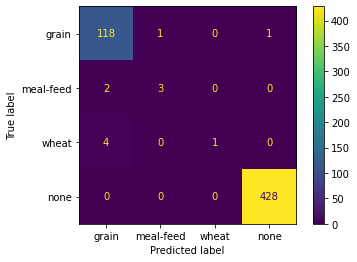

In [ ]:
ConfusionMatrixDisplay.from_estimator(gs_clf, X_test, y_test, labels=['grain', 'meal-feed', 'wheat', 'none'])
plt.show()

### Binary Classification with Respect to 'earn'

To perform the **binary classification** task, the dataset must be changed in order to create two classes. In this case, **the classes were 'earn' and 'not-earn'**. I anticipate this to be a difficult task considering the variety of the 'not-earn' entries might compound the confusion between them and 'earn'.

In [ ]:
dataset_dicts_bin = dataset_dicts

for data in dataset_dicts_bin:
  if data['TOPICS'] != 'earn':
    data['TOPICS'] = 'not-earn'

In [ ]:
df_bin = pd.DataFrame(dataset_dicts)

Then, the data is split in the same manner as above.

In [ ]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(df_bin['BODY'], df_bin['TOPICS'], train_size=0.75, stratify=df_bin['TOPICS'])

For this task, I would have liked to use an SVC again, however that took too much time so I decided to try a different classifier: **Multinomial Naive Bayes**. Utlimately, I would prefer to train and compare several different classifiers, but that was beyond the scope of this format. 

Below, the linquistic data is transformed in the same manner as above using **CountVectorizer** in order to get vectors representing each entry. However, it is not necessary or even beneficial to convert the counts in those vectors via the **TfidfTransformer** for MNB. A range of variables are selected again to yield a reasonable runtime but give some variation. In MNB, prior probabilities are initialized and then updated given the observed instances of entries and the classes to which they belong. For more, see the [User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

**Expect this to run for about 5 minutes using the same SequentialBackend with one worker.**

In [ ]:
bayes_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB())
    ])
    
# Define the optional parameters to be tried with NB.
params_bin = {
    'vect__ngram_range':[(2,2),(1,2),(2,3)],
    'clf__alpha': (0.000001,1),
    'clf__fit_prior':(True, False),
    }

gs_clf_bin = GridSearchCV(bayes_clf, params_bin, cv=3, verbose=2)
gs_clf_bin.fit(X_train_bin, y_train_bin)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(2, 2); total time=   2.5s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(2, 2); total time=   2.6s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(2, 2); total time=   2.7s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(1, 2); total time=   3.9s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(1, 2); total time=   3.3s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(1, 2); total time=   3.3s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(2, 3); total time=   6.5s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(2, 3); total time=   6.6s
[CV] END clf__alpha=1e-06, clf__fit_prior=True, vect__ngram_range=(2, 3); total time=   6.7s
[CV] END clf__alpha=1e-06, clf__fit_prior=False, vect__ngram_range=(2, 2); total time=   2.6s
[CV] END

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': (1e-06, 1),
                         'clf__fit_prior': (True, False),
                         'vect__ngram_range': [(2, 2), (1, 2), (2, 3)]},
             verbose=2)

In [ ]:
# Get the best parameters and print the result
best_params_bin = gs_clf_bin.best_params_
print()
print("Best parameters:")
print("---------------")
for key in best_params_bin.keys():
  print(key + ': ' + str(best_params_bin[key]))
print()


Best parameters:
---------------
clf__alpha: 1
clf__fit_prior: True
vect__ngram_range: (2, 3)



In [ ]:
# Save the trained model with the best parameters
with open('/content/drive/MyDrive/Colab Notebooks/Neumann-Reuters-News-Classification/models/trained_mnbc.sav', 'wb+') as save:
  pickle.dump(gs_clf_bin, save)

Now we get the **predictions** and classification report using the trained model.

In [ ]:
preds_bin = gs_clf_bin.predict(X_test_bin)

In [ ]:
# Get the classification report and print it
report_bin = classification_report(y_test_bin, preds_bin, digits=4)
print("Classification report:")
print("---------------------")
print(report_bin)

Classification report:
---------------------
              precision    recall  f1-score   support

        earn     0.9930    0.8942    0.9410       955
    not-earn     0.9584    0.9974    0.9775      2333

    accuracy                         0.9675      3288
   macro avg     0.9757    0.9458    0.9593      3288
weighted avg     0.9685    0.9675    0.9669      3288



Here, we can see that the **overall performance for predicting the class 'earn' is lower** than in the previous task. However, one issue with Naive Bayes is that it seems to benefit more from more examples than alternative classifiers (see the benchmark examples in the documentation). The classifier also gave a **very high precision score for 'earn'**, meaning that almost everything labeled 'earn' actually belonged to that class. However, the **much lower recall** means that several entries belonging to the class 'earn' were missed. We can investigate this more using the **confusion matrix** below.

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


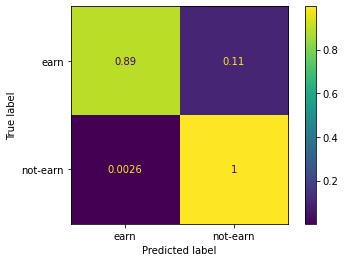

In [ ]:
cm_bin = confusion_matrix(y_test_bin, preds_bin, labels=gs_clf_bin.classes_, normalize='true')
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=gs_clf_bin.classes_)
print("+----------------------------------------------------+")
print(" Confusion Matrix:")
print("+----------------------------------------------------+")
disp_bin.plot()
plt.show()

The interesting part of this analysis is that categorizing and capturing all instances of 'not-earn' was almost perfect, whereas the top-right cell indicates that several entries were also labeled 'not-earn' which should have been 'earn'. I think this is likely due to the issue alluded to earlier that with so many varieties of 'not-earn' entries, and such a high number of them, some are bound to be close enough to 'earn' entries that it is hard to tell them apart. Further research would be on that shared, fuzzy boundary -- where, and in what manner, it shows up. It could be that some entries are mislabeled; it could be that there is some shared vocabulary; it could be that there is additional information that could help separate the two (as in the other sgm labels). 

## Loading and Running the Models

This is intended to stand apart from the previous sections so that the user may use the pre-trained model (saved from above) with new data. Data is accepted in two forms: (1) raw text input, and (2) a structured SGM-formatted file like those found in the data directory. 

Simply run each cell in turn and provide the requested input when prompted.

### Importing Libraries

In [ ]:
import pickle
import numpy as np
import os
import re
from bs4 import BeautifulSoup

### Loading the Pre-Trained Models

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Reuters News Classification/models/trained_lsvc.sav', 'rb') as lsvc_model:
  lsvc = pickle.load(lsvc_model)
lsvc_model.close()
with open('/content/drive/MyDrive/Colab Notebooks/Reuters News Classification/models/trained_mnbc.sav', 'rb') as mnbc_model:
  mnbc = pickle.load(mnbc_model)
mnbc_model.close()

### Defining Functions to Predict Categories

Two functions are defined:


1.   **predict_raw_text**: prompts the user for raw text input in the form of a string and prints the predicted category using the Linear Support Vector Classifier and Multinomial Naive Bayes Classifier trained above.
2.   **predict_sgm_text**: prompts the user for a filepath to an SGM file such as those in the data directory and prints the predicted category for the body of the file using the same classifiers.



In [ ]:
def predict_raw_text():

  text = [input("Enter raw text: ")]

  lsvc_prediction = lsvc.predict(text)
  mnbc_prediction = mnbc.predict(text)

  print("The Support Vector Classifier (multiclass) predicts the category: " + lsvc_prediction.tolist()[0])
  print("The Naive Bayes Classifier (binary) predicts the category: " + mnbc_prediction.tolist()[0])

In [ ]:
def predict_sgm_text():

  filepath = input("Please enter the full filepath of the SGM formatted file: ")

  with open(filepath, 'rb') as fp:
    lines = fp.readlines()
    utf8_safe_lines = [line.decode('utf-8', 'ignore') for line in lines]
    xml_safe_lines = [re.sub(r'&#\d*;', '', line) for line in utf8_safe_lines] # Get rid of problematic strings
    no_newlines = [line.replace('\n', ' ') for line in xml_safe_lines]
  fp.close()

  data = ''.join(no_newlines)

  data_dict = {
      'TITLE': '',
      'BODY': '',
      }

  soup = BeautifulSoup(data, 'xml')

  # Use a try/except block to grab Topics, Title, and Body in case they are empty
  # If empty, the default value remains unchanged
  try:
    if soup.TITLE.contents:
      data_dict['TITLE'] = soup.TITLE.contents[0]
    if soup.BODY.contents:
      body = soup.BODY.contents[0]
      data_dict['BODY'] = soup.BODY.contents[0]
  except AttributeError:
    pass

  if data_dict['BODY'] == '':
    data_dict['BODY'] = data_dict['TITLE']

  lsvc_prediction = lsvc.predict([data_dict['BODY']])
  mnbc_prediction = mnbc.predict([data_dict['BODY']])

  print("The Support Vector Classifier (multiclass) predicts the category: " + lsvc_prediction.tolist()[0])
  print("The Naive Bayes Classifier (binary) predicts the category: " + mnbc_prediction.tolist()[0])
  

### Predicting Categories

When each cell is run, the user will be prompted for information, either raw text or a file path.

In [ ]:
predict_raw_text()

Enter raw text: earnings
The Support Vector Classifier (multiclass) predicts the category: earn
The Naive Bayes Classifier (binary) predicts the category: not-earn


In [ ]:
predict_sgm_text()

Please enter the full filepath of the SGM formatted file: /content/drive/MyDrive/Colab Notebooks/Neumann-Reuters-News-Classification/data/reut2-000.sgm
The Support Vector Classifier (multiclass) predicts the category: cocoa
The Naive Bayes Classifier (binary) predicts the category: not-earn


## References

<a name="1"></a>
[1] Lewis, David. 1997. [Reuters-21578 Text Categorization Collection Data Set](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection). 

<a name="2"></a>
[2]  Pedregosa et al. 2011. [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/). JMLR 12: 2825-2830. Version 1.0.1, released 2021. In particular:


*   sklearn.model_selection.train_test_split
*   sklearn.feature_extraction.text.CountVectorizer
*   sklearn.feature_extraction.text.TfidfTransformer
*   sklearn.pipeline.Pipeline
*   sklearn.model_selection.GridSearchCV
*   sklearn.metrics.classification_report
*   sklearn.metrics.confusion_matrix
*   sklearn.svm.LinearSVC
*   sklearn.naive_bayes.MultinomialNB




<a name="3"></a>
[3] Richard, Leonard. 2021. [Beautiful Soup 4](https://pypi.org/project/beautifulsoup4/). Version 4.10.0. 

<a name="4"></a>
[4] PyData Development Team. 2021. [Pandas](https://pandas.pydata.org/). Version 1.3.2.

<a name="5"></a>
[5] Lewis, David. 1997. [Reuters-21578 Text Categorization Test Collection, Distribution 1.0, README file (v 1.2)](https://drive.google.com/file/d/1ofzs-cYIbp4I1zTXhRX9HEA_bn1hZfac/view?usp=sharing).